<a href="https://colab.research.google.com/github/shivi13102/Earthquake_analysis/blob/main/Predictive_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings

In [4]:
warnings.filterwarnings('ignore')

# Dataset
data = pd.read_csv('/content/merged_table1.csv')

# Select features and target variables
features = ['magnitude', 'depth', 'latitude', 'longitude', 'alert', 'tsunami', 'sig', 'dmin', 'gap']
X = data[features]
y = data[['cdi', 'mmi']]

# Encode categorical features
X = pd.get_dummies(X, columns=['alert'], drop_first=True)

# Handling missing values
X = X.fillna(X.mean())
y = y.fillna(y.mean())

In [5]:
# Use QuantileTransformer for CDI
transformer = QuantileTransformer(output_distribution='normal', n_quantiles=1000)
y['cdi'] = transformer.fit_transform(y[['cdi']])

# Normalize/Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [6]:
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    "XGBoost": MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror', random_state=42)),
    "LightGBM": MultiOutputRegressor(lgb.LGBMRegressor(random_state=42)),
    "CatBoost": MultiOutputRegressor(CatBoostRegressor(random_state=42, verbose=0)),
    "MultiOutput Ridge": MultiOutputRegressor(Ridge(random_state=42)),
    "MultiOutput SVR": MultiOutputRegressor(SVR()),
    "Neural Network": MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500, early_stopping=True))
}

results = {}

In [7]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Inverse transform CDI predictions
    y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
    y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()
    y_test['cdi'] = y_test['cdi'].clip(0)
    y_pred[:, 0] = y_pred[:, 0].clip(0)

    cdi_mse = mean_squared_error(y_test['cdi'], y_pred[:, 0])
    mmi_mse = mean_squared_error(y_test['mmi'], y_pred[:, 1])
    cdi_r2 = r2_score(y_test['cdi'], y_pred[:, 0])
    mmi_r2 = r2_score(y_test['mmi'], y_pred[:, 1])

    results[name] = {
        "CDI MSE": cdi_mse,
        "MMI MSE": mmi_mse,
        "CDI R-squared": cdi_r2,
        "MMI R-squared": mmi_r2
    }


Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 10
[LightGBM] [Info] Start training from score -1.317488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263
[LightGBM] [Info] Number of data points in the train set: 1049, number of used features: 10
[LightGBM] [Info] Start training from score 0.557296
Training CatBoost...
Training MultiOutput Ridge...
Training MultiOutput SVR...
Training Neural Network...


In [8]:
# Train Clustering Model and Get Optimal Clusters
print("Training Clustering Model...")

# Find optimal number of clusters using silhouette scores
silhouette_scores = []
for n_clusters in range(2, 11):  # Testing for 2 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)  # Use scaled data for clustering
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

optimal_n_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_n_clusters}")

# Train final KMeans model on scaled training data
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add Cluster Distances to X_train and X_test
X_train_clustered = np.concatenate((X_train, kmeans.transform(X_scaled[:len(X_train)])), axis=1)
X_test_clustered = np.concatenate((X_test, kmeans.transform(X_scaled[len(X_train):])), axis=1)

# Reset index and add cluster labels to y_train
# Ensure alignment of indices
y_train_reset = y_train.reset_index(drop=True)
clusters = pd.DataFrame(kmeans.predict(X_scaled[:len(X_train)]), columns=['cluster'])
y_train_clustered = pd.concat([y_train_reset, clusters], axis=1)

# Validate Shapes
print(f"X_train_clustered shape: {X_train_clustered.shape}")
print(f"X_test_clustered shape: {X_test_clustered.shape}")
print(f"y_train_clustered shape: {y_train_clustered.shape}")

Training Clustering Model...
Optimal number of clusters: 3
X_train_clustered shape: (1049, 14)
X_test_clustered shape: (263, 14)
y_train_clustered shape: (1049, 3)


In [9]:
models_clustered = {}
for cluster in range(optimal_n_clusters):
    # Filter data for the current cluster
    X_train_cluster = X_train_clustered[y_train_clustered['cluster'] == cluster]
    y_train_cluster = y_train_reset[y_train_clustered['cluster'] == cluster]

    # Train a model for the cluster
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42))
    model.fit(X_train_cluster, y_train_cluster)
    models_clustered[cluster] = model

y_pred = []
for i in range(len(X_test)):
    # Predict cluster for each test sample
    cluster = kmeans.predict(X_test[i].reshape(1, -1))[0]

    # Predict target values using the cluster's model
    y_pred.append(models_clustered[cluster].predict(X_test_clustered[i].reshape(1, -1))[0])

# Convert to numpy array
y_pred = np.array(y_pred)

# Inverse transform predictions for CDI
y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()

# Clip negative values to 0
y_test['cdi'] = y_test['cdi'].clip(0)
y_pred[:, 0] = y_pred[:, 0].clip(0)

cdi_mse = mean_squared_error(y_test['cdi'], y_pred[:, 0])
mmi_mse = mean_squared_error(y_test['mmi'], y_pred[:, 1])
cdi_r2 = r2_score(y_test['cdi'], y_pred[:, 0])
mmi_r2 = r2_score(y_test['mmi'], y_pred[:, 1])

In [10]:
results["Clustered Random Forest"] = {
    "CDI MSE": cdi_mse,
    "MMI MSE": mmi_mse,
    "CDI R-squared": cdi_r2,
    "MMI R-squared": mmi_r2
}


In [11]:
for name, metrics in results.items():
    print(f"\n{name} Results:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")

# Plotting Predictions for Random Forest
rf_model = list(models.values())[0] #Gets the first model (Random Forest)
y_pred = rf_model.predict(X_test)
y_pred[:, 0] = transformer.inverse_transform(y_pred[:, [0]]).flatten()
y_test['cdi'] = transformer.inverse_transform(y_test[['cdi']]).flatten()
y_test['cdi'] = y_test['cdi'].clip(0)
y_pred[:, 0] = y_pred[:, 0].clip(0)

plt.figure(figsize=(12, 6))


Random Forest Results:
CDI MSE: 0.04818934852555353
MMI MSE: 0.011794867830247144
CDI R-squared: 0.6206919778963564
MMI R-squared: 0.5704930427123917

XGBoost Results:
CDI MSE: 0.13446556071799703
MMI MSE: 0.011736691294710803
CDI R-squared: -4.627109827411857
MMI R-squared: 0.5726115256935804

LightGBM Results:
CDI MSE: 0.2664882880345491
MMI MSE: 0.01051367604012745
CDI R-squared: -85.70447154471555
MMI R-squared: 0.6171472990716715

CatBoost Results:
CDI MSE: 0.34572285020917404
MMI MSE: 0.00990386822784998
CDI R-squared: -2.8048369829137518e+31
MMI R-squared: 0.6393532874516211

MultiOutput Ridge Results:
CDI MSE: 0.49820080493453156
MMI MSE: 0.014290082697241469
CDI R-squared: -4.041885116220454e+31
MMI R-squared: 0.479630460721163

MultiOutput SVR Results:
CDI MSE: 0.3483155613265727
MMI MSE: 0.014403023094336529
CDI R-squared: -2.8258715544605603e+31
MMI R-squared: 0.4755177663688993

Neural Network Results:
CDI MSE: 0.4193277158280209
MMI MSE: 0.016485126807755244
CDI R-square

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Actual vs. Predicted CDI')

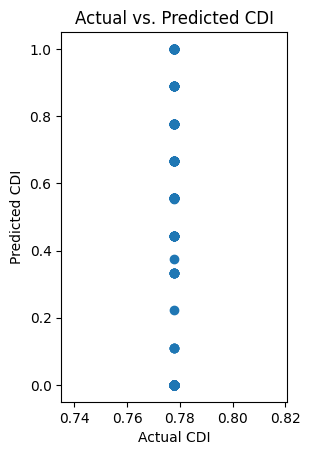

In [12]:
plt.subplot(1, 2, 1)
plt.scatter(y_test['cdi'], y_pred[:, 0])
plt.plot([y_test['cdi'].min(), y_test['cdi'].max()], [y_test['cdi'].min(), y_test['cdi'].max()], 'r--')
plt.xlabel("Actual CDI")
plt.ylabel("Predicted CDI")
plt.title("Actual vs. Predicted CDI")

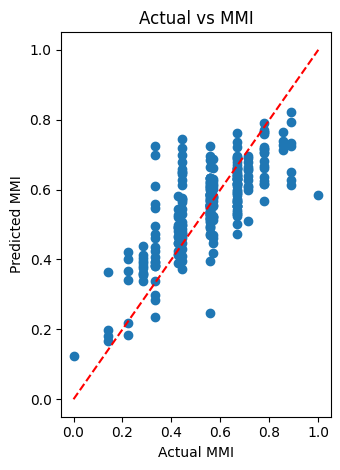

In [13]:
plt.subplot(1, 2, 2)
plt.scatter(y_test['mmi'], y_pred[:, 1])
plt.plot([y_test['mmi'].min(), y_test['mmi'].max()], [y_test['mmi'].min(), y_test['mmi'].max()], 'r--')
plt.xlabel("Actual MMI")
plt.ylabel("Predicted MMI")
plt.title("Actual vs MMI")
plt.tight_layout()
plt.show()


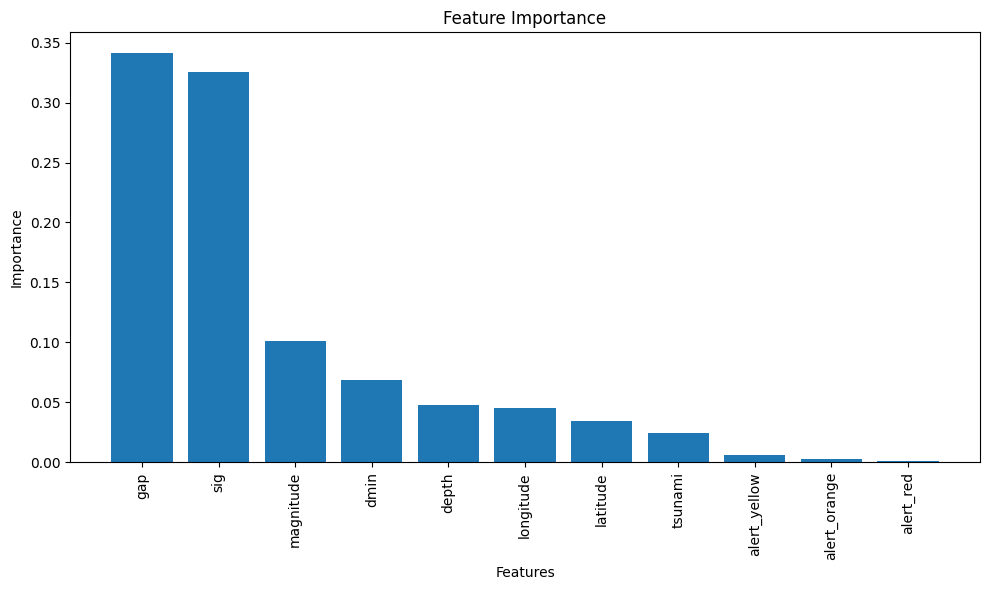

In [14]:
# Feature importance for Random Forest (example)
try:
    feature_importances = rf_model.estimators_[0].feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Feature importance is not available for this model (e.g., SVR).")


Several machine learning models were evaluated for the prediction of both CDI and MMI. While the models showed varying degrees of success, significant issues were identified with the CDI predictions, likely due to data transformations and the distributional characteristics of the CDI variable. The models consistently failed to accurately predict CDI, yielding negative R-squared values (except for Random Forest, which still had a high MSE and clustered predictions) and indicating a need for further investigation into the CDI data and modeling approach.

For MMI prediction, the Random Forest model achieved a moderate R-squared of approximately 0.62 and a relatively low MSE, demonstrating the best overall performance among the tested models for this target variable. Therefore, for the purpose of this report, the Random Forest model is considered the most suitable for MMI prediction, although further improvements are possible through feature engineering, hyperparameter tuning, or exploring alternative modeling techniques.